# Initial Ideas for evaporator code

Here's some simple ideas for how best to code an evaporating body

#### Physical approach

Let's think about the real physics going on, and see if we can adapt known models to account for that.

The cause of the signal in evaporator transits is not the planet, but the dust cloud.

To me, this dust cloud has three possibilities:
 * Spherical cloud around planet which decreases density with distance
 * Smeared tail behind planet which decreases density with distance
 * Smeared tail in front of planet which decreases density with distance
 
In all three cases, we could iteractively fit a Mandel+Agol transit model to account for the change in size over time. e.g:
 
 <img src="MandelAgolIdeas.png">
 
 This is not quite what happens, because there's thinks like Roche lobe overflow at L1/L2, but maybe it's enough for a general model?

Alternatively, and possibly more realistically, these dust grains are pushed onto a new orbit, so potentially we should include a Keplerian signal for that which should include for curvature in the tail.

In any case, we would then have a couple of hyper parameters for each transit governing:
* the direction of motion of the dust cloud w.r.t. the planet (+ being leading, 0 being sphere, - being trailing)
* the rate of dispersion over time
* total dust production (which should governe depth)

In this sort of model, the dust would be conserved - i.e. the density of the dust between transit model iterations would be proportional to the change in area (i.e. dispersion)

##### Forward-scattering

 <img src="K222_model.jpg">

In the previous models (e.g. with Kepler), they have included a term to model the effect that this tail of dust is actually *scattering* (ie not just blocking) the light. That means less light in transit, but also extra light around transit due to the fact that the tail is directing light back to the observer.

Personally I think this is too much to include in the model because: 
* 3D reflection geometry is non-trivial
* It depends on both dust grain size & separation - two unknowns
* The amount of scattering will certainly be less with TESS because of the redder wavelength

But maybe we can include some sort of density-dependent boost effect around central transit with a couple of floating parameters:
* dust density : boost height ratio (for the height of the Gaussian)
* reflection angle (for the width of the Gaussian)

##### Pseudo code:

Parameters
* planet period = $P$
* planet transit time = $t_0$
* planet impact param = $b$
* either:
    * dust production mean = $D_\mu$
    * dust production std = $D_\sigma$
* or:
    * SHM kernel for dust production in celerite with parameters mean $D_\mu$ and lengthscale $l$.
* dust speed = $v$
* dust dispersion = $\delta$
* density to reflection boost = $b_D$
* reflection angle = $\Theta_b$

For each transit:
* draw dust production ($D_i$) from the $D_\mu$ and $D_\sigma$ distributions
* Create some number of steps to iterate over from -pi/2 to 0 in phase producing phantom planets at each

For each step:
* Using $v$ and the orbital velocity of the planet from ($P$) we generate an eccentric orbit for the M+A model. The new orbit is either at aphelion (for trailing tail) or perihelion (leading tail) at the 
* We then compute the new "phantom planet" orbit given $P$, $v$, $t_l$, $t_c$
* Depending on the $\delta$ and $t_l$ we calculate a new phantom planet radius, and a new "density" (e.g. alpha) for the transit.

Then, for each transit:
* Sum all the transit lightcurves for the phantom planets.
* Use $b_D$ and $\Theta_b$ to add a reflection boost

In [44]:
from astropy import units as u
from astropy import constants as c

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import exoplanet as xo
import theano.tensor as tt
import theano.tensor.extra_ops as ttx

import pandas as pd
dat=np.genfromtxt("k1255_lc.dat")

import pymc3 as pm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
c.G

<<class 'astropy.constants.codata2018.CODATA2018'> name='Gravitational constant' value=6.6743e-11 uncertainty=1.5e-15 unit='m3 / (kg s2)' reference='CODATA 2018'>

Let's use the Hill sphere for a Mars-mass body as our initial Radius:

$r_{\mathrm {H} }\approx a(1-e){\sqrt[{3}]{\frac {m}{3M}}}$

In [3]:
n_pnts=20000

#Taking a snippet of KIC1255 data for the model:
t=dat[:n_pnts,0]
flux= dat[:n_pnts,1]-np.nanmedian(dat[:n_pnts,1])
flux_err= dat[:n_pnts,2]
cadence=np.nanmedian(np.diff(t))

In [4]:
#Orbital params from BLS/candidate - we can fix these here as they should be good enough
t_0=566.824+0.5
P=0.6535538

Checking the data works ok:

(-0.02, 0.01)

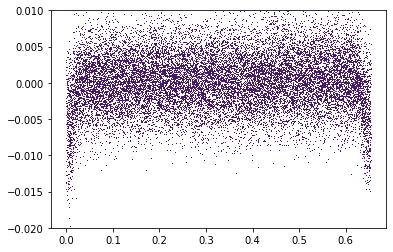

In [139]:
plt.plot((t-t_0)%P,flux,',')
plt.ylim(-0.02,0.01)

In [140]:
# initial parameters
use_gp=True
init_planet_mass=0.1 #Roughly Mars mass - should be undetectably small yet big enough to have a big hill sphere.
n_steps=50
phase_coverage=0.1

#Counting number of transits to model, and assigning time to each nearby transit:
phase        = (t-t_0)/P
rounded_phase= np.round(phase)
trns_numbers = np.unique(rounded_phase)
phase_index  = np.vstack([[rounded_phase==n_tr] for n_tr in trns_numbers])

#Stellar params from e.g. TIC:
Rs=1.0#Rs=pm.Normal('Rs',mu=1.0,sd=0.1)
Ms=1.0#Ms=pm.Normal('Ms',mu=1.0,sd=0.15)

In [141]:
phase_index.shape

(22, 20000)

In [11]:
# THe model:

with pm.Model() as model:
    #b can just be unit uniform:
    b=pm.Uniform('b',lower=0.0,upper=1.00)
    #This is no longer used, the offset was just 0.5P
    #t_offset=pm.Uniform('t_offset',lower=0.0,upper=P)
    
    #For now, let's just model lightcurve depth for every transit:
    log_depths=pm.Bound(pm.Normal, upper=-1,lower=-10)("log_depths", mu=-5, sigma=6.0,shape=len(trns_numbers))
    
    '''
    #This is where we could put a GP:
    
    from exoplanet import estimate_inverse_gamma_parameters
    from exoplanet.gp import terms, GP

    #Getting depths with GP
    if use_gp:
        #Getting dust production from a GP
        #dust_mean=pm.Uniform('dust_mean',lower=0,upper=0.5)
        log_mean_depths = pm.Normal("log_mean_depths", mu=-3, sigma=6.0)
        S1 = pm.InverseGamma(
            "S1", **estimate_inverse_gamma_parameters(0.5 ** 2, 10.0 ** 2)
        )
        w1 = pm.InverseGamma(
            "w1", **estimate_inverse_gamma_parameters(2 * np.pi / 20.0, 0.125*np.pi)
        )
        # Set up the kernel an GP
        kernel = terms.SHOTerm(S_tot=S1, w0=w1, Q=1.0 / np.sqrt(2))
        sigma = pm.Lognormal("sigma", mu=np.log(0.0), sigma=10)
        log_depth_gp = GP(kernel, trns_numbers, sigma ** 2 + tt.zeros(len(trns_numbers)), mean=log_mean_dust)
        
        #Using our GP to predict log depth and applying this:
        log_depth_gp.compute(trns_numbers,sigma)
        dust_prod_pred = tt.exp(log_depth_gp.predict(trns_numbers,return_var=False))
    '''
    
    #This is the relative speed of the dust with respect to the planet. i.e. <0 = in-falling. >0 = propelled outward.
    #NB - dust_vel<<1.41 (as sqrt(2)*v_circ = unbound from th solar system!).
    dust_vel=pm.Bound(pm.Normal, upper=1.25,lower=0.5)('dust_vel',mu=1.0,sd=0.033)
    
    #Defining t_periasteron as the time when the phatom planet left the real planet in the preceeding part of the orbit
    # We have to redefine t_periasteron like this because we specifically want to model the fact that dust knocked off the surface *does not arrive at the time of transit*
    #In the case of an in-falling dust body, we need to flip this by pi as periasteron becomes apasteron 
    if tt.lt(dust_vel,1):
        phantom_t_peris = -0.5*per_phantom - np.linspace(-1*phase_coverage*P, 0.0, n_steps)
        phantom_omega = np.linspace(0.5*np.pi-1*phase_coverage*2*np.pi, 0.5*np.pi, n_steps)%(np.pi*2)
        ecc_phantom = 1-dust_vel**2

    else:
        phantom_t_peris = -1*np.linspace(-1*phase_coverage*P, 0.0, n_steps)
        phantom_omega = np.linspace(1.5*np.pi-1*phase_coverage*2*np.pi, 0.5*np.pi, n_steps)%(np.pi*2)
        ecc_phantom = dust_vel**2-1
    
    #We want to define our dusty "phantom planets" as kicked off their planet and moving along eccentric orbits
    #As velocity should be the same, we should always have the same eccentricity, and the same "period", so initialising here:
    sma_circ    = (((6.67e-11*(u.Msun.to(u.kg))*Ms*(P*86400)**2)/(4*np.pi**2))**(1/3))/(u.AU.to(u.m))
    per_phantom = (np.sqrt((4*np.pi**2*((sma_circ*u.AU.to(u.m))/(1+ecc_phantom))**3)/(6.67e-11*(u.Msun.to(u.kg))*Ms)))/86400
    # Initial positions of the orbits of our phantom planets (where pi/2 = planet phase)

    #As dust dispersion is constant and our steps are constant, we should also always have the same dispersion for each transit, so initialising here:
    init_planet_ratio = ((sma_circ*u.AU.to(u.m))*(init_planet_mass*(u.Mearth.to(u.kg))/(3*Ms*(u.Msun.to(u.kg))))**(1/3))/(Rs*(u.Rsun.to(u.m))) #roche lobe for Mars-sized body on this orbit
    log_rad_growth    = pm.Uniform("log_rad_growth",lower=-6,upper=1)
    # We parameterize the rate of growth of the dusty "planets" with log_rad_growth
    planet_ratios     = init_planet_ratio+(1+np.exp(log_rad_growth))**np.linspace(1,2,n_steps)
    planet_ratios     = (planet_ratios-planet_ratios[0])/(2*planet_ratios[-1])+init_planet_ratio #Limiting it at 0.5
    
    # Dispersion is the parameter dealing with the net throughput of each dust "planet"
    # We will start at 0.25 for the Hill Sphere and decrease
    # How steep that decrease is can be varied with "log_dust_dispersion"
    log_dust_dispersion=pm.Uniform("log_dust_dispersion",lower=2,upper=10)
    dispersion        = pm.Deterministic("dispersion", 0.25/(1.0+np.exp(log_dust_dispersion))**(np.linspace(0,1,n_steps)))
    
    
    #Defining limb darkening
    u_star_tess = xo.distributions.QuadLimbDark("u_star_tess", testval=np.array([0.3, 0.2]))
    
    #Defining the orbit using stellar params (Rs, Ms) and period, omega, t_peri, ecc and b:
    orbit = xo.orbits.KeplerianOrbit(r_star=Rs,m_star=Ms,
                                     period=tt.tile(per_phantom,n_steps),
                                     omega=phantom_omega,
                                     t_periastron=phantom_t_peris,
                                     ecc=tt.tile(ecc_phantom,n_steps),
                                     b=tt.tile(b,n_steps))
    
    #To track parameters for debugging I intialise some lists here:
    models=[]
    disp_lcs=[]
    #all_lcs=[]
    mins=[]
    
    #looping over each transit:
    for n_tr in range(len(trns_numbers)):
        #For each of the phantom planet orbits, we generate a transit lightcurve with radius ratio determined by log_rad_growth
        #Here, t is transformed to phase between -0.5 and 0.5 so that the above eccentric/non-similar-period phantom planets are always correctly phased
        lc = xo.LimbDarkLightCurve(u_star_tess).get_light_curve(orbit=orbit,r=planet_ratios,
                                                                t=t[rounded_phase==trns_numbers[n_tr]]-t_0-trns_numbers[n_tr]*P+0.5*P,
                                                                use_in_transit=True)
        
        #all_lcs+=[pm.Deterministic("all_lcs_"+str(n_tr),lc)]
        #Multiplying the lightcurve by the dispersion as a function of time/dust-planet-size, and summing on 1D axis
        disp_lcs+=[pm.Deterministic("disp_lc_"+str(n_tr),tt.sum(lc*dispersion.dimshuffle('x',0),axis=1))]
        #Getting the minimum transit depth from the model. Clipping this so minimum is never 0 (which -> NaNs)
        mins+=[pm.Deterministic("mins_"+str(n_tr),tt.clip(tt.min(disp_lcs[n_tr]),-1e5,-1e-20))]
        #Reparameterising the transit depth using the minimum and the log_depths param
        models+=[np.exp(log_depths[n_tr])*-1*(disp_lcs[n_tr]/mins[n_tr])]
        
    #Stacking individual transits:
    stacked_lc = pm.Deterministic("stacked_lc",tt.concatenate(models))
    
    #Likelihood of the model:
    pm.Normal("likelihood",mu=stacked_lc, sigma=flux_err, observed=flux)
    
    #return final_model

NameError: name 'per_phantom' is not defined

In [ ]:
with model:
    map_estimate = pm.find_MAP(model=model, method="powell")

In [297]:
import seaborn as sns
sns.set_palette('viridis')

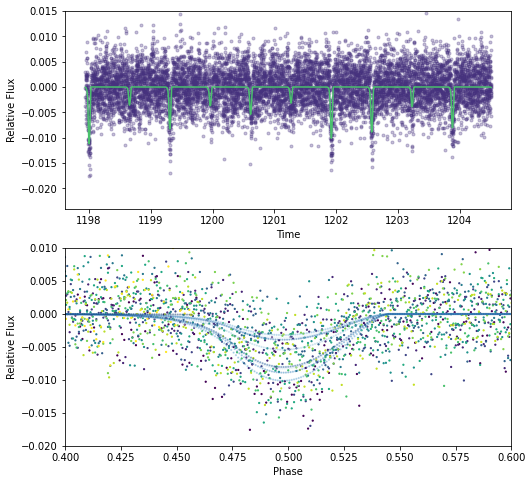

In [298]:
plt.figure(figsize=(8,8))
plt.subplot(211)
plt.plot(t,flux,'.',alpha=0.3)
plt.plot(t,map_estimate['stacked_lc'],'-',color='C4')

plt.ylim(-0.024,0.015)
plt.xlabel("Time")
plt.ylabel("Relative Flux")

plt.subplot(212)
plt.scatter((phase-0.5)%1,flux,c=phase-phase[0],cmap='viridis',s=1.5)
plt.scatter((phase-0.5)%1,map_estimate['stacked_lc'],c=phase-phase[0],cmap='Blues',s=1.5,alpha=0.3)
plt.xlim(0.4,0.6)

plt.ylim(-0.02,0.01)
plt.xlabel("Phase")
plt.ylabel("Relative Flux")
plt.savefig("WorkingStackedTransitModel.png",dpi=300)


### Update 1

- use offset phase (e.g. folded on t=0) to get lightcurves at the same time
- use depths to 

In [222]:
sns.set_palette("viridis",6)

Leading Tail


/Users/hosborn/transits/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Leading Tail


/Users/hosborn/transits/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Leading Tail


/Users/hosborn/transits/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Following Tail


/Users/hosborn/transits/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Following Tail


/Users/hosborn/transits/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Following Tail


/Users/hosborn/transits/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


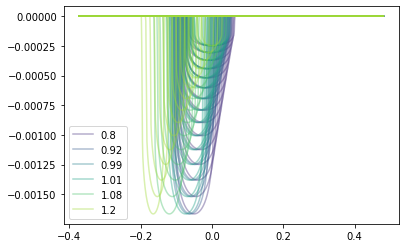

In [231]:
n_steps=15
phase_coverage=0.125 #Max at around 0.2
b=0.2
log_depths  = np.random.normal(-3,1.5,len(trns_numbers))
dust_vel    =  0.99  #This ONLY limits eccentricity
sma_circ    = (((6.67e-11*(u.Msun.to(u.kg))*Ms*(P*86400)**2)/(4*np.pi**2))**(1/3))/(u.AU.to(u.m))

ndv=0

for dust_vel in [0.8,0.92,0.99,1.01,1.08,1.2]:
    #As dust dispersion is constant and our steps are constant, we should also always have the same dispersion for each transit, so initialising here:
    init_planet_ratio = ((sma_circ*u.AU.to(u.m))*(init_planet_mass*(u.Mearth.to(u.kg))/(3*Ms*(u.Msun.to(u.kg))))**(1/3))/(Rs*(u.Rsun.to(u.m))) #roche lobe for Mars-sized body on this orbit
    log_rad_growth    = -3

    # We parameterize the rate of growth of the dusty "planets" with log_rad_growth
    planet_ratios     = init_planet_ratio+(1+np.exp(log_rad_growth))**np.linspace(2,1,n_steps)
    planet_ratios     = (planet_ratios-planet_ratios[-1])/(2*planet_ratios[0])+init_planet_ratio #Limiting it at 0.5

    if dust_vel<1:
        print("Leading Tail")
        #In the leading tail case:
        ecc_phantom = 1-dust_vel**2
        #Period taken from Kepler's 3rd law combined with updated s.m.a. given eccentrcity and aphelion (previous s.m.a.)
        per_phantom = (np.sqrt((4*np.pi**2*((sma_circ*u.AU.to(u.m))/(1+ecc_phantom))**3)/(6.67e-11*(u.Msun.to(u.kg))*Ms)))/86400
        #Creating "phantom" times of perasteron for N phantom planets between 0.0 (real transit) and -phase_coverage*P
        #In the case of these orbits, phantom_t_peris is offset by 0.5*P_phantom to account for the fact the they leave the planet at aphelion
        phantom_t_peris = np.linspace(0.5*per_phantom-phase_coverage, 0.5*per_phantom, n_steps)
        #0.5*per_phantom - np.linspace(0, -1*phase_coverage*per_phantom, n_steps)
        #Omega, the angle from perihelion to the observer, is then set from 1.5pi to 1.5pi+2pi*phase_coverage
        phantom_omega = np.linspace(1.5*np.pi-1*phase_coverage*2*np.pi, 1.5*np.pi, n_steps)

    else:
        print("Following Tail")
        ecc_phantom = dust_vel**2-1
        per_phantom = (np.sqrt((4*np.pi**2*((sma_circ*u.AU.to(u.m))/(1+ecc_phantom))**3)/(6.67e-11*(u.Msun.to(u.kg))*Ms)))/86400
        phantom_t_peris = np.linspace(-1*phase_coverage, 0, n_steps)
        phantom_omega = np.linspace(0.5*np.pi-1*phase_coverage*2*np.pi, 0.5*np.pi, n_steps)%(np.pi*2)

    # Initial positions of the orbits of our phantom planets (where pi/2 = planet phase)


    # Dispersion is the parameter dealing with the net throughput of each dust "planet"
    # We will start at 0.25 for the Hill Sphere and decrease
    # How steep that decrease is can be varied with "log_dust_dispersion"
    log_dust_dispersion=5
    dispersion        = 0.25/(1.0+np.exp(log_dust_dispersion))**(np.linspace(0,1,n_steps))

    #Defining t_periasteron as the time when the phatom planet left the real planet in the preceeding part of the orbit
    # We have to redefine t_periasteron like this because we specifically want to model the fact that dust knocked off the surface *does not arrive at the time of transit*
    #In the case of an in-falling dust body, we need to flip this by pi as periasteron becomes apasteron 

    #Defining limb darkening
    u_star_tess = np.array([0.3, 0.2])

    #Defining the orbit using stellar params (Rs, Ms) and period, omega, t_peri, ecc and b:
    orbit = xo.orbits.KeplerianOrbit(r_star=Rs,m_star=Ms,
                                     period=np.tile(per_phantom,n_steps),
                                     omega=phantom_omega,
                                     t_periastron=phantom_t_peris,
                                     ecc=np.tile(ecc_phantom,n_steps),
                                     b=np.tile(b,n_steps))

    #Getting the lightcurve for all orbits, for all times (where the times have been adjusted to be ~0)
    lc = xo.LimbDarkLightCurve(u_star_tess).get_light_curve(orbit=orbit,r=planet_ratios,
                                                            t=P*(phase-np.round(phase))).eval()
    #For short-period orbits, we really need to make sure that the second orbits are not included...
    lc[((P*(phase-np.round(phase))[:,np.newaxis]<orbit.t0.eval()[np.newaxis,:]-0.5*per_phantom)+(P*(phase-np.round(phase))[:,np.newaxis]>orbit.t0.eval()[np.newaxis,:]+0.5*per_phantom))]=0

    #Incorporating dispersion and finding the minimum in order to normalise lightcurve to depth=1.0
    disp_lc = np.sum(lc*dispersion[np.newaxis,:],axis=1)
    lc_min  = np.clip(np.min(disp_lc),-1e5,-1e-20)

    #Incorporating depth differences by multipliying depths (N_Tr, 1) by a phase index (N_tr x N_lc) and summing along N_tr axis:
    depth_adjusts = np.sum(np.exp(log_depths)[:,np.newaxis]*phase_index,axis=0)

    #Multiplying normalised lc by the depth:
    model_lc = -1*(disp_lc/lc_min)*depth_adjusts

    for n in range(n_steps):
        if n==0:
            _=plt.plot((phase-np.round(phase))[:820],lc[:820,n],'-',c='C'+str(ndv),alpha=0.4,label=str(dust_vel))
        else:
            _=plt.plot((phase-np.round(phase))[:820],lc[:820,n],'-',c='C'+str(ndv),alpha=0.4)
    ndv+=1
plt.legend()

### Adapting to do outward and inward velocity (not along orbital path):

In [6]:
# initial parameters
use_gp=True
init_planet_mass=0.1 #Roughly Mars mass - should be undetectably small yet big enough to have a big hill sphere.
n_steps=50
phase_coverage=0.1

#Counting number of transits to model, and assigning time to each nearby transit:
phase        = (t-t_0)/P
rounded_phase= np.round(phase)
trns_numbers = np.unique(rounded_phase)
phase_index  = np.vstack([[rounded_phase==n_tr] for n_tr in trns_numbers])

#Stellar params from e.g. TIC:
Rs=1.0#Rs=pm.Normal('Rs',mu=1.0,sd=0.1)
Ms=1.0#Ms=pm.Normal('Ms',mu=1.0,sd=0.15)

v_circ: 245338.36795087406 P: 0.6535538 sma: 0.014738567614425341
Velocity in = Leading Tail
vel: -0.2 new_sma 0.010837182069430382 new per: 0.41207188240628656 ecc: 0.6000000000000015


/Users/hosborn/transits/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


[3.30174571e-02 3.81969095e-02 4.24399067e-02 4.55654554e-02
 4.73721074e-02 4.76477562e-02 4.61886573e-02 4.28302341e-02
 3.74898439e-02 3.02164700e-02 2.12348288e-02 1.09650504e-02
 2.77555756e-17]
Velocity in = Leading Tail
vel: -0.08 new_sma 0.012776150844682128 new per: 0.5274708611456335 ecc: 0.3919183588453124


/Users/hosborn/transits/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


[0.04184199 0.04346582 0.04422583 0.04405056 0.04287964 0.04067102
 0.03740925 0.03311415 0.02784847 0.02172309 0.01489792 0.00757741
 0.        ]
Velocity in = Leading Tail
vel: -0.01 new_sma 0.014450992856579362 new per: 0.6345194753544494 ecc: 0.14106735979667076


/Users/hosborn/transits/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


[0.02411749 0.02362696 0.02280615 0.0216588  0.02019394 0.01842622
 0.01637619 0.01407033 0.01154081 0.00882516 0.00596548 0.00300762
 0.        ]
vel: 0.0 new_sma 0.014738567614425288 new per: 0.6535537999999964 ecc: 0.0


/Users/hosborn/transits/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


[-7.21644966e-16 -6.66133815e-16 -5.96744876e-16 -5.27355937e-16
 -4.85722573e-16 -4.02455846e-16 -3.60822483e-16 -2.77555756e-16
 -2.22044605e-16 -1.87350135e-16 -1.07552856e-16 -3.29597460e-17
  6.36916254e-18]
Velocity out = Following Tail
vel: 0.01 new_sma 0.0150408894932394 new per: 0.6737654043920348 ecc: 0.14177446878756575


/Users/hosborn/transits/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


[-2.38681166e-02 -2.28411168e-02 -2.15644612e-02 -2.00597777e-02
 -1.83493207e-02 -1.64557445e-02 -1.44019300e-02 -1.22108597e-02
 -9.90553190e-03 -7.50890928e-03 -5.04389477e-03 -2.53332842e-03
  4.88564241e-18]
Velocity out = Following Tail
vel: 0.08 new_sma 0.01768062333784222 new per: 0.8587065690020267 ecc: 0.40792156108741817


/Users/hosborn/transits/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


[-5.33502359e-02 -5.07523963e-02 -4.76174133e-02 -4.40199674e-02
 -4.00268541e-02 -3.56979717e-02 -3.10872892e-02 -2.62437665e-02
 -2.12122147e-02 -1.60340956e-02 -1.07482652e-02 -5.39166911e-03
  3.21310866e-18]
Velocity out = Following Tail
vel: 0.2 new_sma 0.026318870740045006 new per: 1.5595500021837656 ecc: 0.6633249580710759
[-7.11244504e-02 -6.73483396e-02 -6.28947622e-02 -5.78844572e-02
 -5.24168065e-02 -4.65744606e-02 -4.04269759e-02 -3.40336957e-02
 -2.74460535e-02 -2.07094422e-02 -1.38647602e-02 -6.94972093e-03
  2.30212088e-18]


/Users/hosborn/transits/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


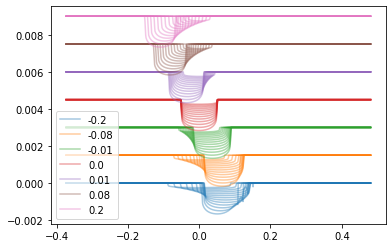

In [60]:
n_steps=13
phase_coverage=0.2 #Max at around 0.2
b=0.2
log_depths  = np.random.normal(-3,1.5,len(trns_numbers))
dust_vel    =  0.01  #This ONLY limits eccentricity
sma_circ    = (((c.G.value*(u.Msun.to(u.kg))*Ms*(P*86400)**2)/(4*np.pi**2))**(1/3))/(u.AU.to(u.m))
v_circ      = (2*np.pi*sma_circ*(u.AU.to(u.m)))/(P*86400)

print("v_circ:",v_circ,"P:",P,"sma:",sma_circ)

ndv=0

for dust_vel in [-0.2,-0.08,-0.01,0.0,0.01,0.08,0.2]:
    #As dust dispersion is constant and our steps are constant, we should also always have the same dispersion for each transit, so initialising here:
    init_planet_ratio = ((sma_circ*u.AU.to(u.m))*(init_planet_mass*(u.Mearth.to(u.kg))/(3*Ms*(u.Msun.to(u.kg))))**(1/3))/(Rs*(u.Rsun.to(u.m))) #roche lobe for Mars-sized body on this orbit
    log_rad_growth    = -3

    # We parameterize the rate of growth of the dusty "planets" with log_rad_growth
    planet_ratios     = init_planet_ratio+(1+np.exp(log_rad_growth))**np.linspace(2,1,n_steps)
    planet_ratios     = (planet_ratios-planet_ratios[-1])/(2*planet_ratios[0])+init_planet_ratio #Limiting it at 0.5
    
    sma_phantom = 1/(u.AU.to(u.m)*(2/(sma_circ*u.AU.to(u.m)) - ((1+dust_vel)*v_circ)**2/(c.G.value*Ms*(u.Msun.to(u.kg)))))
    #1/(2/(sma_circ*u.AU.to(u.m)) - ((1+dust_vel)*v_circ)**2/(c.G.value*Ms*(u.Msun.to(u.kg))))
    per_phantom = P*(sma_phantom/sma_circ)**(3/2)
    
    #Setting eccentricities:
    if dust_vel<0:
        print("Velocity in = Leading Tail")
        ecc_phantom = np.sqrt(sma_circ/sma_phantom-1)
    elif dust_vel>0:
        print("Velocity out = Following Tail")
        ecc_phantom = np.sqrt(1-sma_circ/sma_phantom)
    elif dust_vel==0:
        ecc_phantom = 0.0
        
    #Setting omega and t_periasterons:
    if dust_vel<0:
        print("vel:",dust_vel,"new_sma",sma_phantom,"new per:",per_phantom,"ecc:",ecc_phantom)
        #In the case of velocity outwards, we get an ellipse with periapse 0.25P (pi/2) before release point
        # As omega is defined as 0.5pi in transit, we get omegas from -phase_cov to 0 
        phantom_omega=np.linspace(1.5*np.pi - phase_coverage*2*np.pi, 1.5*np.pi, n_steps) 
        # And t_peri is from -0.5*P_p-phase_cov to -0.25*P
        phantom_t_peris = np.linspace(0.5*per_phantom - phase_coverage*P, 0.5*per_phantom, n_steps)
    else:
        print("vel:",dust_vel,"new_sma",sma_phantom,"new per:",per_phantom,"ecc:",ecc_phantom)
        #In the case of velocity inwards, we get an ellipse with periapse 0.25P (pi/2) after release point
        # For omega, which is pi/2 at transit, we get pi-phase_cov to pi 
        phantom_omega = np.linspace(0.5*np.pi - phase_coverage*2*np.pi, 0.5*np.pi, n_steps) 
        phantom_t_peris = np.linspace(-1*phase_coverage*P, 0.0, n_steps)

    # Dispersion is the parameter dealing with the net throughput of each dust "planet"
    # We will start at 0.25 for the Hill Sphere and decrease
    # How steep that decrease is can be varied with "log_dust_dispersion"
    log_dust_dispersion=5
    dispersion        = 0.25/(1.0+np.exp(log_dust_dispersion))**(np.linspace(0,1,n_steps))

    #Defining t_periasteron as the time when the phatom planet left the real planet in the preceeding part of the orbit
    # We have to redefine t_periasteron like this because we specifically want to model the fact that dust knocked off the surface *does not arrive at the time of transit*
    #In the case of an in-falling dust body, we need to flip this by pi as periasteron becomes apasteron 

    #Defining limb darkening
    u_star_tess = np.array([0.3, 0.2])

    #Defining the orbit using stellar params (Rs, Ms) and period, omega, t_peri, ecc and b:
    orbit = xo.orbits.KeplerianOrbit(r_star=Rs,m_star=Ms,
                                     period=np.tile(per_phantom,n_steps),
                                     omega=phantom_omega,
                                     t_periastron=phantom_t_peris,
                                     ecc=np.tile(ecc_phantom,n_steps),
                                     b=np.tile(b,n_steps))

    #Getting the lightcurve for all orbits, for all times (where the times have been adjusted to be ~0)
    lc = xo.LimbDarkLightCurve(u_star_tess).get_light_curve(orbit=orbit,r=planet_ratios,
                                                            t=P*(phase-np.round(phase))).eval()
    #For short-period orbits, we really need to make sure that the second orbits are not included...
    lc[((P*(phase-np.round(phase))[:,np.newaxis]<orbit.t0.eval()[np.newaxis,:]-0.5*per_phantom)+(P*(phase-np.round(phase))[:,np.newaxis]>orbit.t0.eval()[np.newaxis,:]+0.5*per_phantom))]=0

    #Incorporating dispersion and finding the minimum in order to normalise lightcurve to depth=1.0
    disp_lc = np.sum(lc*dispersion[np.newaxis,:],axis=1)
    lc_min  = np.clip(np.min(disp_lc),-1e5,-1e-20)

    #Incorporating depth differences by multipliying depths (N_Tr, 1) by a phase index (N_tr x N_lc) and summing along N_tr axis:
    depth_adjusts = np.sum(np.exp(log_depths)[:,np.newaxis]*phase_index,axis=0)

    #Multiplying normalised lc by the depth:
    model_lc = -1*(disp_lc/lc_min)*depth_adjusts

    for n in range(n_steps):
        if n==0:
            _=plt.plot((phase-np.round(phase))[:820],ndv*1.5e-3+lc[:820,n],'-',c='C'+str(ndv),alpha=0.4,label=str(dust_vel))
        else:
            _=plt.plot((phase-np.round(phase))[:820],ndv*1.5e-3+lc[:820,n],'-',c='C'+str(ndv),alpha=0.4)
    print(orbit.t0.eval())
    ndv+=1
plt.legend()

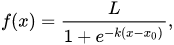

In [117]:
# THe model:

n_steps=23

phase        = (t-t_0)/P
rounded_phase= np.round(phase)
trns_numbers = np.unique(rounded_phase)
phase_index  = np.vstack([[rounded_phase==n_tr] for n_tr in trns_numbers])


with pm.Model() as model:
    #b can just be unit uniform:
    b=pm.Uniform('b',lower=0.0,upper=1.05)
    #This is no longer used, the offset was just 0.5P
    #t_offset=pm.Uniform('t_offset',lower=0.0,upper=P)
    
    #For now, let's just model lightcurve depth for every transit:
    log_depths=pm.Bound(pm.Normal, upper=-1,lower=-10)("log_depths", mu=-5, sigma=6.0,shape=len(trns_numbers))
    
    '''
    #This is where we could put a GP:
    
    from exoplanet import estimate_inverse_gamma_parameters
    from exoplanet.gp import terms, GP

    #Getting depths with GP
    if use_gp:
        #Getting dust production from a GP
        #dust_mean=pm.Uniform('dust_mean',lower=0,upper=0.5)
        log_mean_depths = pm.Normal("log_mean_depths", mu=-3, sigma=6.0)
        S1 = pm.InverseGamma(
            "S1", **estimate_inverse_gamma_parameters(0.5 ** 2, 10.0 ** 2)
        )
        w1 = pm.InverseGamma(
            "w1", **estimate_inverse_gamma_parameters(2 * np.pi / 20.0, 0.125*np.pi)
        )
        # Set up the kernel an GP
        kernel = terms.SHOTerm(S_tot=S1, w0=w1, Q=1.0 / np.sqrt(2))
        sigma = pm.Lognormal("sigma", mu=np.log(0.0), sigma=10)
        log_depth_gp = GP(kernel, trns_numbers, sigma ** 2 + tt.zeros(len(trns_numbers)), mean=log_mean_dust)
        
        #Using our GP to predict log depth and applying this:
        log_depth_gp.compute(trns_numbers,sigma)
        dust_prod_pred = tt.exp(log_depth_gp.predict(trns_numbers,return_var=False))
    '''    

    #This is the relative speed of the dust with respect to the planet. i.e. <0 = in-falling. >0 = propelled outward.
    #NB - dust_vel<0.41 (as sqrt(2)*v_circ = unbound from the solar system!).    
    dust_vel=pm.Bound(pm.Normal, upper=0.4,lower=-0.9)('dust_vel',mu=1.0,sd=0.033)
    
    #We want to define our dusty "phantom planets" as kicked off their planet and moving along eccentric orbits
    #Here we will assume the dust is kicked off _radially_ with no change in angular velocity
    #This means all the orbits will have the same eccentricity, and the same "period", so initialising here:
    # Initial positions of the orbits of our phantom planets (where pi/2 = planet phase)
    sma_circ    = (((6.67e-11*(u.Msun.to(u.kg))*Ms*(P*86400)**2)/(4*np.pi**2))**(1/3))/(u.AU.to(u.m))
    sma_phantom = 1/(u.AU.to(u.m)*(2/(sma_circ*u.AU.to(u.m)) - ((1+dust_vel)*v_circ)**2/(c.G.value*Ms*(u.Msun.to(u.kg)))))
    per_phantom = P*(sma_phantom/sma_circ)**(3/2)

    #NB - similarly, the dust velocity should be on a trajectory that doesnt intersect with the star (because this ruins the transit models)
    # Uses a sigmoid function L/(1+exp(K*(sma-sma_min))), where L=-100 (invalid sma) and K=1000 (steepness)
    #pm.Potential("sma_min",-100.0/(1+np.exp(1000*(sma_phantom-(sma_circ+Rs*(u.Rsun.to(u.AU)))/2))))
    
    #Defining t_periasteron as the time when the phatom planet left the real planet in the preceeding part of the orbit
    # We have to redefine t_periasteron like this because we specifically want to model the fact that dust knocked off the surface *does not arrive at the time of transit*
    #In the case of an in-falling dust body, we need to flip this by pi as periasteron becomes apasteron 
    if tt.lt(dust_vel,0):
        ecc_phantom = pm.Deterministic("ecc_phantom", tt.sqrt(sma_circ/sma_phantom-1))
        phantom_omega   = np.linspace(1.5*np.pi - phase_coverage*2*np.pi, 1.5*np.pi, n_steps) 
        phantom_t_peris = pm.Deterministic("phantom_t_peris", 0.5*per_phantom - np.linspace(phase_coverage*P, 0.0, n_steps))
    elif tt.gt(dust_vel,0):
        ecc_phantom = pm.Deterministic("ecc_phantom", tt.sqrt(1-sma_circ/sma_phantom))
        phantom_omega = np.linspace(0.5*np.pi - phase_coverage*2*np.pi, 0.5*np.pi, n_steps) 
        phantom_t_peris = pm.Deterministic("phantom_t_peris", np.linspace(-1*phase_coverage*P, 0.0, n_steps))
    else:
        ecc_phantom = pm.Deterministic("ecc_phantom",0.0)
        phantom_omega = np.linspace(0.5*np.pi - phase_coverage*2*np.pi, 0.5*np.pi, n_steps) 
        phantom_t_peris = pm.Deterministic("phantom_t_peris", np.linspace(-1*phase_coverage*P, 0.0, n_steps))

    #As dust dispersion is constant and our steps are constant, we should also always have the same dispersion for each transit, so initialising here:
    init_planet_ratio = ((sma_circ*u.AU.to(u.m))*(init_planet_mass*(u.Mearth.to(u.kg))/(3*Ms*(u.Msun.to(u.kg))))**(1/3))/(Rs*(u.Rsun.to(u.m))) #roche lobe for Mars-sized body on this orbit
    log_rad_growth    = pm.Uniform("log_rad_growth",lower=-6,upper=0.0,testval=-1)
    # We parameterize the rate of growth of the dusty "planets" with log_rad_growth
    planet_ratios_init= init_planet_ratio+(1+np.exp(log_rad_growth))**np.linspace(2,1,n_steps)
    planet_ratios     = pm.Deterministic("planet_ratios",(planet_ratios-planet_ratios[-1])/(2*planet_ratios[0])+init_planet_ratio) #Limiting it at 0.5
    #Limiting it at 0.5
    
    # Dispersion is the parameter dealing with the net throughput of each dust "planet"
    # We will start at 0.25 for the Hill Sphere and decrease
    # How steep that decrease is can be varied with "log_dust_dispersion"
    log_dust_dispersion=pm.Uniform("log_dust_dispersion",lower=2,upper=10)
    dispersion        = pm.Deterministic("dispersion", 0.25/(1.0+np.exp(log_dust_dispersion))**(np.linspace(0,1,n_steps)))
    
    #Defining limb darkening
    u_star_tess = xo.distributions.QuadLimbDark("u_star_tess", testval=np.array([0.3, 0.2]))
    
    #Defining the orbit using stellar params (Rs, Ms) and period, omega, t_peri, ecc and b:
    orbit = xo.orbits.KeplerianOrbit(r_star=Rs,m_star=Ms,
                                     period=tt.tile(per_phantom,n_steps),
                                     omega=phantom_omega,
                                     t_periastron=phantom_t_peris,
                                     ecc=tt.tile(ecc_phantom,n_steps),
                                     b=tt.tile(b,n_steps))
    
    #Getting the lightcurve for all orbits, for all times (where the times have been adjusted to be ~0)
    lc = xo.LimbDarkLightCurve(u_star_tess).get_light_curve(orbit=orbit,r=planet_ratios,
                                                            t=tt.clip(P*(phase-np.round(phase)),-0.5*per_phantom,0.5*per_phantom))
    #For short-period orbits, we really need to make sure that the second orbits are not included...
    #lc[((P*(phase-np.round(phase))[:,np.newaxis]<orbit.t0.dimshuffle('x',0)-0.5*per_phantom)+(P*(phase-np.round(phase))[:,np.newaxis]>orbit.t0.dimshuffle('x',0)+0.5*per_phantom))]=0

    #Incorporating dispersion and finding the minimum in order to normalise lightcurve to depth=1.0
    disp_lc = tt.sum(lc*dispersion.dimshuffle('x',0),axis=1)
    lc_min  = tt.clip(tt.min(disp_lc),-1e5,-1e-20)

    #Incorporating depth differences by multipliying depths (N_Tr, 1) by a phase index (N_tr x N_lc) and summing along N_tr axis:
    depth_adjusts = tt.sum(tt.exp(log_depths).dimshuffle(0,'x')*phase_index,axis=0)

    #Multiplying normalised lc by the depth:
    model_lc = -1*(disp_lc/lc_min)*depth_adjusts

    #Likelihood of the model:
    pm.Normal("likelihood",mu=model_lc, sigma=flux_err, observed=flux)
    
    #return final_model

/Users/hosborn/transits/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [118]:
with model:
    print("before",model.check_test_point())
    map_estimate = pm.find_MAP(model=model, method="powell")

MissingInputError: Input 0 of the graph (indices start from 0), used to compute sigmoid(log_rad_growth_interval__), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error.

In [92]:
map_estimate

{'b_interval__': array(5.16866145),
 'log_depths_interval__': array([0.22314376, 0.22314376, 0.22314376, 0.22314376, 0.22314376,
        0.22314376, 0.22314376, 0.22314376, 0.22314376, 0.22314376,
        0.22314376, 0.22314376, 0.22314376, 0.22314376, 0.22314376,
        0.22314376, 0.22314376, 0.22314376, 0.22314376, 0.22314376,
        0.22314376, 0.22314376]),
 'dust_vel_interval__': array(44.67969676),
 'log_rad_growth_interval__': array(-69.70533951),
 'log_dust_dispersion_interval__': array(47.26762572),
 'u_star_tess_quadlimbdark__': array([39.26071092, 53.10048615]),
 'b': array(1.04405704),
 'log_depths': array([-4.99999954, -4.99999954, -4.99999954, -4.99999954, -4.99999954,
        -4.99999954, -4.99999954, -4.99999954, -4.99999954, -4.99999954,
        -4.99999954, -4.99999954, -4.99999954, -4.99999954, -4.99999954,
        -4.99999954, -4.99999954, -4.99999954, -4.99999954, -4.99999954,
        -4.99999954, -4.99999954]),
 'dust_vel': array(0.4),
 'phantom_t_peris': array

In [66]:
(sma_circ+Rs*(u.Rsun.to(u.AU)))/2

0.009694517437693749

array([-0.03644486,  0.12586382])

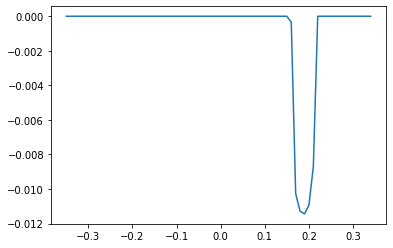

In [27]:
phantom_t0s

array([-0.13071076, -0.06535538,  0.        ,  0.06535538,  0.13071076,
        0.19606614,  0.26142152,  0.3267769 ,  0.39213228,  0.45748766,
        0.52284304,  0.58819842,  0.6535538 ])

In [23]:
0.5*(0.8587065690020267-0.6535537999999964)

0.10257638450101514

In [25]:
xo.orbits.KeplerianOrbit?

array([0.00623208, 0.01240648, 0.01847279, 0.02441879, 0.03023102,
       0.03589462, 0.04139313, 0.04670826, 0.05181964, 0.05670454,
       0.06133753, 0.06569008, 0.06973018, 0.0734218 , 0.07672437])

In [255]:
np.sqrt(sma_circ/sma_phantom-1)

0.14106735979667076

In [243]:
v_circ

245338.36795087406

In [244]:
(c.G.value*Ms*(u.Msun.to(u.kg)))

1.3271244e+20

In [245]:
c.G

<<class 'astropy.constants.codata2018.CODATA2018'> name='Gravitational constant' value=6.6743e-11 uncertainty=1.5e-15 unit='m3 / (kg s2)' reference='CODATA 2018'>

In [246]:
sma_circ

0.014738567614425341

In [208]:
planet_ratios[-1]

0.014712969591966472

In [209]:
planet_ratios

array([0.0381135 , 0.03640406, 0.03470055, 0.03300294, 0.03131122,
       0.02962535, 0.02794532, 0.02627112, 0.02460271, 0.02294009,
       0.02128322, 0.0196321 , 0.0179867 , 0.01634699, 0.01471297])

In [194]:
per_phantom/P

0.9708756576037832

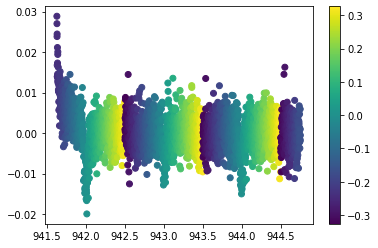

In [116]:
plt.scatter(phase[:3000],flux[:3000],c=P*(phase[:3000]-np.round(phase[:3000])))
plt.colorbar()

In [104]:
0.14639978/per_phantom,0.14639978/P

(0.29733919220035837, 0.22400570542165008)

In [108]:
0.14639978/per_phantom,0.14639978/P

(0.2307254318998153, 0.22400570542165008)

In [90]:
phantom_omega

array([3.14159265, 3.07427281, 3.00695297, 2.93963313, 2.87231328,
       2.80499344, 2.7376736 , 2.67035376, 2.60303391, 2.53571407,
       2.46839423, 2.40107439, 2.33375454, 2.2664347 , 2.19911486])

In [71]:
phantom_omega/(np.pi*2)

array([0.75      , 0.76071429, 0.77142857, 0.78214286, 0.79285714,
       0.80357143, 0.81428571, 0.825     , 0.83571429, 0.84642857,
       0.85714286, 0.86785714, 0.87857143, 0.88928571, 0.9       ])

In [47]:
np.column_stack((phantom_t_peris,phantom_omega,planet_ratios,dispersion))

array([[-3.26747393e-01,  4.71238898e+00,  1.47129696e-02,
         2.50000000e-01],
       [-3.36083883e-01,  4.80214877e+00,  1.63469924e-02,
         1.74834252e-01],
       [-3.45420373e-01,  4.89190856e+00,  1.79866960e-02,
         1.22268063e-01],
       [-3.54756862e-01,  4.98166835e+00,  1.96321001e-02,
         8.55065810e-02],
       [-3.64093352e-01,  5.07142814e+00,  2.12832246e-02,
         5.97979164e-02],
       [-3.73429842e-01,  5.16118793e+00,  2.29400892e-02,
         4.18188959e-02],
       [-3.82766332e-01,  5.25094772e+00,  2.46027141e-02,
         2.92455015e-02],
       [-3.92102822e-01,  5.34070751e+00,  2.62711192e-02,
         2.04524615e-02],
       [-4.01439312e-01,  5.43046730e+00,  2.79453245e-02,
         1.43031632e-02],
       [-4.10775802e-01,  5.52022709e+00,  2.96253504e-02,
         1.00027314e-02],
       [-4.20112292e-01,  5.60998688e+00,  3.13112169e-02,
         6.99528023e-03],
       [-4.29448782e-01,  5.69974667e+00,  3.30029444e-02,
      

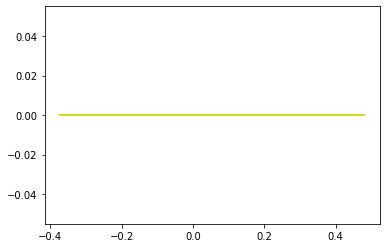

In [155]:
import seaborn as sns
sns.set_palette('viridis',15)


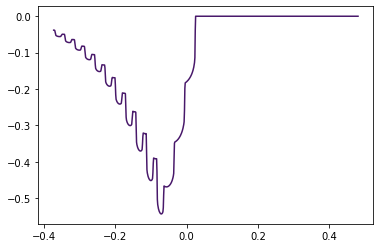

In [228]:
plt.plot((phase-np.round(phase))[:820],model_lc[:820])

In [165]:
phantom_t_peris

array([0.03421834, 0.04355483, 0.05289131, 0.06222779, 0.07156427,
       0.08090076, 0.09023724, 0.09957372, 0.10891021, 0.11824669,
       0.12758317, 0.13691965, 0.14625614, 0.15559262, 0.1649291 ])

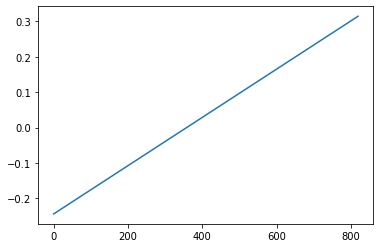

In [99]:
plt.plot(P*(phase-np.round(phase))[:820])

In [64]:
per_phantom

0.5645643451031196

In [65]:
P

0.6535538

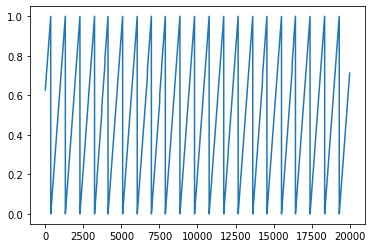

In [62]:
plt.plot(phase%1)

(-0.05, 0.01)

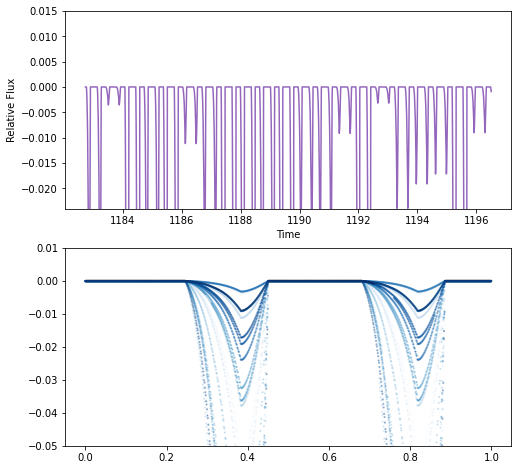

In [63]:
plt.figure(figsize=(8,8))
plt.subplot(211)
#plt.plot(t,flux,'.',alpha=0.3)
plt.plot(t,model_lc,'-',color='C4')

plt.ylim(-0.024,0.015)
plt.xlabel("Time")
plt.ylabel("Relative Flux")

plt.subplot(212)
plt.scatter(phase%1,model_lc,c=phase-phase[0],cmap='Blues',s=1.5,alpha=0.3)

plt.ylim(-0.05,0.01)

/Users/hosborn/transits/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
  0%|          | 0/5000 [00:00<?, ?it/s]/Users/hosborn/transits/lib/python3.7/site-packages/scipy/optimize/_minimize.py:500: RuntimeWarning: Method powell does not use gradient information (jac).
  RuntimeWarning)
/Users/hosborn/transits/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem_

{'b_interval__': array(24.34592809), 'log_depths_interval__': array([-61.05649464, -60.85415475, -60.11943027, -59.8170445 ,
       -59.42512443, -59.93831593, -60.19900313, -58.83078257,
       -59.78302611, -59.54325728, -59.70697407, -59.61617236,
       -60.09621777, -60.73780168, -60.05423156, -60.13236658,
       -59.80152139, -59.08663161, -59.24046064, -58.97982861,
       -59.964474  , -42.53493689]), 'dust_vel_interval__': array(-1.19457286), 'log_rad_growth_interval__': array(-22.97745476), 'log_dust_dispersion_interval__': array(49.97082216), 'u_star_tess_quadlimbdark__': array([30.83667759, 37.29539184]), 'b': array(1.), 'log_depths': array([-2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2.]), 'dust_vel': array(0.67433156), 'log_rad_growth': array(-6.), 'r_pl': array([0.01471297, 0.01473781, 0.01476264, 0.01478748, 0.01481232,
       0.01483717, 0.01486201, 0.01488685, 0.0149117 , 0.01493654,
       0.014961

(-0.02, 0.01)

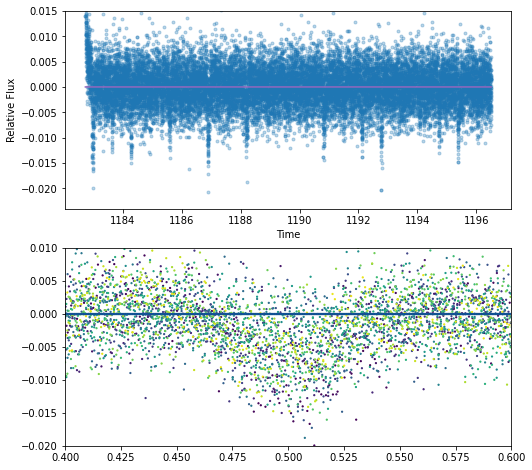

In [52]:
with pm.Model() as model:
    #b can just be unit uniform:
    b=pm.Uniform('b',lower=0.0,upper=1.00)
    #This is no longer used, the offset was just 0.5P
    #t_offset=pm.Uniform('t_offset',lower=0.0,upper=P)
    
    #For now, let's just model lightcurve depth for every transit:
    log_depths  = pm.Bound(pm.Normal, upper=-1, lower=-2)("log_depths", mu=-2, sigma=6.0, shape=len(trns_numbers))

    #This is the relative speed of the dust with respect to the planet. i.e. <0 = in-falling. >0 = propelled outward.
    #NB - dust_vel<<1.41 (as sqrt(2)*v_circ = unbound from th solar system!).
    dust_vel    = pm.Bound(pm.Normal, upper=1.25, lower=0.5)('dust_vel', mu=1.0, sd=0.033)
    
    #We want to define our dusty "phantom planets" as kicked off their planet and moving along eccentric orbits
    #As velocity should be the same, we should always have the same eccentricity, and the same "period", so initialising here:
    sma_circ    = (((6.67e-11*(u.Msun.to(u.kg))*Ms*(P*86400)**2)/(4*np.pi**2))**(1/3))/(u.AU.to(u.m))
    ecc_phantom = abs(dust_vel**2-1)
    per_phantom = (np.sqrt((4*np.pi**2*((sma_circ*u.AU.to(u.m))/(1+ecc_phantom))**3)/(6.67e-11*(u.Msun.to(u.kg))*Ms)))/86400
    # Initial positions of the orbits of our phantom planets (where pi/2 = planet phase)

    #As dust dispersion is constant and our steps are constant, we should also always have the same dispersion for each transit, so initialising here:
    init_planet_ratio = ((sma_circ*u.AU.to(u.m))*(init_planet_mass*(u.Mearth.to(u.kg))/(3*Ms*(u.Msun.to(u.kg))))**(1/3))/(Rs*(u.Rsun.to(u.m))) #roche lobe for Mars-sized body on this orbit
    log_rad_growth    = pm.Uniform("log_rad_growth",lower=-6,upper=1)
    # We parameterize the rate of growth of the dusty "planets" with log_rad_growth
    planet_ratios     = init_planet_ratio+(1+np.exp(log_rad_growth))**np.linspace(1,2,n_steps)
    planet_ratios     = (planet_ratios-planet_ratios[0])/(2*planet_ratios[-1])+init_planet_ratio #Limiting it at 0.5
    pm.Deterministic("r_pl",planet_ratios)

    # Dispersion is the parameter dealing with the net throughput of each dust "planet"
    # We will start at 0.25 for the Hill Sphere and decrease
    # How steep that decrease is can be varied with "log_dust_dispersion"
    log_dust_dispersion=pm.Uniform("log_dust_dispersion",lower=2,upper=10)
    dispersion        = pm.Deterministic("dispersion", 0.25/(1.0+np.exp(log_dust_dispersion))**(np.linspace(0,1,n_steps)))
    
    #Defining t_periasteron as the time when the phatom planet left the real planet in the preceeding part of the orbit
    # We have to redefine t_periasteron like this because we specifically want to model the fact that dust knocked off the surface *does not arrive at the time of transit*
    #In the case of an in-falling dust body, we need to flip this by pi as periasteron becomes apasteron 
    if tt.lt(dust_vel,1):
        phantom_t_peris = -0.5*per_phantom - np.linspace(-1*phase_coverage*P, 0.0, n_steps)
        phantom_omega = np.linspace(0.5*np.pi-1*phase_coverage*2*np.pi, 0.5*np.pi, n_steps)%(np.pi*2)
    else:
        phantom_t_peris = -1*np.linspace(-1*phase_coverage*P, 0.0, n_steps)
        phantom_omega = np.linspace(1.5*np.pi-1*phase_coverage*2*np.pi, 1.5*np.pi, n_steps)%(np.pi*2)
    
    #Defining limb darkening
    u_star_tess = xo.distributions.QuadLimbDark("u_star_tess", testval=np.array([0.3, 0.2]))
    
    #Defining the orbit using stellar params (Rs, Ms) and period, omega, t_peri, ecc and b:
    orbit = xo.orbits.KeplerianOrbit(r_star=Rs,m_star=Ms,
                                     period=tt.tile(per_phantom,n_steps),
                                     omega=phantom_omega,
                                     t_periastron=phantom_t_peris,
                                     ecc=tt.tile(ecc_phantom,n_steps),
                                     b=tt.tile(b,n_steps))
    
    #Getting the lightcurve for all orbits, for all times (where the times have been adjusted to be ~0)
    lc = xo.LimbDarkLightCurve(u_star_tess).get_light_curve(orbit=orbit,r=planet_ratios,
                                                            t=phase-np.round(phase))
    
    #Incorporating dispersion and finding the minimum in order to normalise lightcurve to depth=1.0
    disp_lc = pm.Deterministic("disp_lc", tt.sum(lc*dispersion.dimshuffle('x',0),axis=1))
    lc_min  = pm.Deterministic("lc_min", tt.clip(tt.min(disp_lc),-1e5,-1e-20))
    
    #Incorporating depth differences by multipliying depths (N_Tr, 1) by a phase index (N_tr x N_lc) and summing along N_tr axis:
    depth_adjusts = pm.Deterministic("depth_adjusts", tt.sum(tt.exp(log_depths).dimshuffle(0,'x')*phase_index,axis=0))
    
    #Multiplying normalised lc by the depth:
    model_lc = pm.Deterministic("model_lc", tt.squeeze(-1*(disp_lc/lc_min)*depth_adjusts))
    
    #Likelihood of the model:
    pm.Normal("likelihood", mu=model_lc, sigma=flux_err, observed=flux)
    
    #return final_model

with model:
    map_estimate = pm.find_MAP(model=model, method="powell")
    
print(map_estimate)

plt.figure(figsize=(8,8))
plt.subplot(211)
plt.plot(t,flux,'.',alpha=0.3)
plt.plot(t,map_estimate['model_lc'],'-',color='C4')

plt.ylim(-0.024,0.015)
plt.xlabel("Time")
plt.ylabel("Relative Flux")

plt.subplot(212)
plt.scatter((phase-0.5)%1,flux,c=phase-phase[0],cmap='viridis',s=1.5)
plt.scatter((phase-0.5)%1,map_estimate['model_lc'],c=phase-phase[0],cmap='Blues',s=1.5,alpha=0.3)
plt.xlim(0.4,0.6)

plt.ylim(-0.02,0.01)

In [51]:
np.sum(np.exp(map_estimate['log_depths'])[:,np.newaxis]*phase_index,axis=0)

array([0.00673795, 0.00673795, 0.00673795, ..., 0.00673795, 0.00673795,
       0.00673795])

In [42]:
map_estimate

{'b_interval__': array(25.00553115),
 'log_depths_interval__': array([-67.3635664 , -67.3635664 , -67.3635664 , -67.3635664 ,
        -67.3635664 , -67.3635664 , -67.3635664 , -67.3635664 ,
        -67.3635664 , -67.3635664 , -67.3635664 , -67.3635664 ,
        -67.3635664 , -67.3635664 , -67.3635664 , -67.3635664 ,
        -67.3635664 , -67.3635664 , -67.3635664 , -67.3635664 ,
        -67.3635664 , -45.61693341]),
 'dust_vel_interval__': array(-1.19457308),
 'log_rad_growth_interval__': array(-20.27274681),
 'log_dust_dispersion_interval__': array(49.93558266),
 'u_star_tess_quadlimbdark__': array([28.91094691, 36.74637508]),
 'b': array(1.),
 'log_depths': array([-4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4.]),
 'dust_vel': array(0.67433153),
 'log_rad_growth': array(-5.99999999),
 'log_dust_dispersion': array(10.),
 'dispersion': array([2.50000000e-01, 2.03848763e-01, 1.66217272e-01, 1.35532741e-01,
        1.10

(-0.02, 0.01)

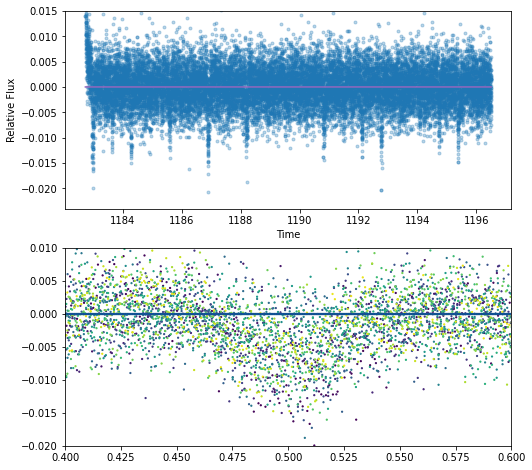

In [53]:
plt.figure(figsize=(8,8))
plt.subplot(211)
plt.plot(t,flux,'.',alpha=0.3)
plt.plot(t,map_estimate['model_lc'],'-',color='C4')

plt.ylim(-0.024,0.015)
plt.xlabel("Time")
plt.ylabel("Relative Flux")

plt.subplot(212)
plt.scatter((phase-0.5)%1,flux,c=phase-phase[0],cmap='viridis',s=1.5)
plt.scatter((phase-0.5)%1,map_estimate['model_lc'],c=phase-phase[0],cmap='Blues',s=1.5,alpha=0.3)
plt.xlim(0.4,0.6)

plt.ylim(-0.02,0.01)

In [303]:
# -*- coding: utf-8 -*-

__all__ = ["InterpolatedLightCurve"]

import numpy as np
import theano.tensor as tt

from exoplanet.utils import eval_in_model


def interp(n, x, xmin, xmax, dx, func):
    xp = tt.arange(xmin - dx, xmax + 2.5 * dx, dx)
    yp = func(xp)

    y0 = yp[:-3, n]
    y1 = yp[1:-2, n]
    y2 = yp[2:-1, n]
    y3 = yp[3:, n]

    a0 = y1
    a1 = -y0 / 3.0 - 0.5 * y1 + y2 - y3 / 6.0
    a2 = 0.5 * (y0 + y2) - y1
    a3 = 0.5 * ((y1 - y2) + (y3 - y0) / 3.0)

    inds = tt.cast(tt.floor((x - xmin) / dx), "int64")
    x0 = (x - xp[inds + 1]) / dx
    return a0[inds] + a1[inds] * x0 + a2[inds] * x0 ** 2 + a3[inds] * x0 ** 3


class InterpolatedLightCurve:
    def __init__(
        self, base_light_curve, num_phase, num_planets=None, **kwargs
    ):
        self.base_light_curve = base_light_curve
        self.num_phase = int(num_phase)
        self.num_planets = num_planets

    def get_light_curve(
        self,
        orbit=None,
        r=None,
        t=None,
        texp=None,
        oversample=7,
        order=0,
        use_in_transit=None,
        light_delay=False,
    ):
        if self.num_planets is None:
            try:
                vec = orbit.period.tag.test_value
            except AttributeError:
                try:
                    vec = eval_in_model(orbit.period)
                except TypeError:
                    raise ValueError(
                        "Can't compute num_planets, please provide a value"
                    )
            num_planets = len(np.atleast_1d(vec))
        else:
            num_planets = int(self.num_planets)

        if num_planets <= 1:
            func = _wrapper(
                self.base_light_curve,
                orbit=orbit,
                r=r,
                texp=texp,
                oversample=oversample,
                order=order,
                use_in_transit=use_in_transit,
                light_delay=light_delay,
            )
            mn = orbit.t0
            mx = orbit.t0 + orbit.period
            return interp(
                0,
                tt.mod(t - orbit.t0, orbit.period) + orbit.t0,
                mn,
                mx,
                (mx - mn) / (self.num_phase + 1),
                func,
            )[:, None]

        ys = []
        for n in range(num_planets):
            func = _wrapper(
                self.base_light_curve,
                orbit=orbit,
                r=r,
                texp=texp,
                oversample=oversample,
                order=order,
                use_in_transit=use_in_transit,
                light_delay=light_delay,
            )
            mn = orbit.t0[n]
            mx = orbit.t0[n] + orbit.period[n]
            ys.append(
                interp(
                    n,
                    tt.mod(t - orbit.t0[n], orbit.period[n]) + orbit.t0[n],
                    mn,
                    mx,
                    (mx - mn) / (self.num_phase + 1),
                    func,
                )
            )

        return tt.stack(ys, axis=-1)


class _wrapper:
    def __init__(self, base_light_curve, *args, **kwargs):
        self.base_light_curve = base_light_curve
        self.args = args
        self.kwargs = kwargs

    def __call__(self, x):
        kwargs = dict(t=x, **self.kwargs)
        return self.base_light_curve.get_light_curve(*self.args, **kwargs)

In [44]:

with pm.Model() as model:
    #b can just be unit uniform:
    b=pm.Uniform('b',lower=0.0,upper=1.00)
    #This is no longer used, the offset was just 0.5P
    #t_offset=pm.Uniform('t_offset',lower=0.0,upper=P)
    
    #For now, let's just model lightcurve depth for every transit:
    log_depths=pm.Bound(pm.Normal, upper=-1,lower=-10)("log_depths", mu=-5, sigma=6.0,shape=len(trns_numbers))
    
    #This is the relative speed of the dust with respect to the planet. i.e. <0 = in-falling. >0 = propelled outward.
    #NB - dust_vel<<1.41 (as sqrt(2)*v_circ = unbound from th solar system!).
    dust_vel=pm.Bound(pm.Normal, upper=1.25,lower=0.5)('dust_vel',mu=1.0,sd=0.033)
    
    #We want to define our dusty "phantom planets" as kicked off their planet and moving along eccentric orbits
    #As velocity should be the same, we should always have the same eccentricity, and the same "period", so initialising here:
    sma_circ    = (((6.67e-11*(u.Msun.to(u.kg))*Ms*(P*86400)**2)/(4*np.pi**2))**(1/3))/(u.AU.to(u.m))
    ecc_phantom = abs(dust_vel**2-1)
    per_phantom = (np.sqrt((4*np.pi**2*((sma_circ*u.AU.to(u.m))/(1+ecc_phantom))**3)/(6.67e-11*(u.Msun.to(u.kg))*Ms)))/86400
    # Initial positions of the orbits of our phantom planets (where pi/2 = planet phase)

    #As dust dispersion is constant and our steps are constant, we should also always have the same dispersion for each transit, so initialising here:
    init_planet_ratio = ((sma_circ*u.AU.to(u.m))*(init_planet_mass*(u.Mearth.to(u.kg))/(3*Ms*(u.Msun.to(u.kg))))**(1/3))/(Rs*(u.Rsun.to(u.m))) #roche lobe for Mars-sized body on this orbit
    log_rad_growth    = pm.Uniform("log_rad_growth",lower=-6,upper=1)
    # We parameterize the rate of growth of the dusty "planets" with log_rad_growth
    planet_ratios     = init_planet_ratio+(1+np.exp(log_rad_growth))**np.linspace(1,2,n_steps)
    planet_ratios     = (planet_ratios-planet_ratios[0])/(2*planet_ratios[-1])+init_planet_ratio #Limiting it at 0.5
    pm.Deterministic("r_pl",planet_ratios)
    # Dispersion is the parameter dealing with the net throughput of each dust "planet"
    # We will start at 0.25 for the Hill Sphere and decrease
    # How steep that decrease is can be varied with "log_dust_dispersion"
    log_dust_dispersion=pm.Uniform("log_dust_dispersion",lower=2,upper=10)
    dispersion        = pm.Deterministic("dispersion", 0.25/(1.0+np.exp(log_dust_dispersion))**(np.linspace(0,1,n_steps)))
    
    #Defining t_periasteron as the time when the phatom planet left the real planet in the preceeding part of the orbit
    # We have to redefine t_periasteron like this because we specifically want to model the fact that dust knocked off the surface *does not arrive at the time of transit*
    #In the case of an in-falling dust body, we need to flip this by pi as periasteron becomes apasteron 
    if tt.lt(dust_vel,0):
        phantom_t_peris = -0.5*per_phantom - np.linspace(-1*phase_coverage*P, 0.0, n_steps)
        phantom_omega = np.linspace(0.5*np.pi-1*phase_coverage*2*np.pi, 0.5*np.pi, n_steps)%(np.pi*2)
    else:
        phantom_t_peris = -1*np.linspace(-1*phase_coverage*P, 0.0, n_steps)
        phantom_omega = np.linspace(1.5*np.pi-1*phase_coverage*2*np.pi, 1.5*np.pi, n_steps)%(np.pi*2)
    
    #Defining limb darkening
    u_star_tess = xo.distributions.QuadLimbDark("u_star_tess", testval=np.array([0.3, 0.2]))
    
    #Defining the orbit using stellar params (Rs, Ms) and period, omega, t_peri, ecc and b:
    orbit = xo.orbits.KeplerianOrbit(r_star=Rs,m_star=Ms,
                                     period=tt.tile(per_phantom,n_steps),
                                     omega=phantom_omega,
                                     t_periastron=phantom_t_peris,
                                     ecc=tt.tile(ecc_phantom,n_steps),
                                     b=tt.tile(b,n_steps))
    
    #To track parameters for debugging I intialise some lists here:
    models=[]
    disp_lcs=[]
    #all_lcs=[]
    mins=[]
    
    base_lc = xo.LimbDarkLightCurve(u_star_tess).get_light_curve(orbit=orbit,r=planet_ratios,
                                                            t=np.linspace(-0.5*P,0.5*P,2000),
                                                            use_in_transit=True)
    
    lc = InterpolatedLightCurve(base_lc, 2000, 1)
    
    
    #looping over each transit:
    for n_tr in range(len(trns_numbers)):
        #For each of the phantom planet orbits, we generate a transit lightcurve with radius ratio determined by log_rad_growth
        #Here, t is transformed to phase between -0.5 and 0.5 so that the above eccentric/non-similar-period phantom planets are always correctly phased
        
        lc.get_light_curve(orbit=orbit,r=planet_ratios,
                           t=t[rounded_phase==trns_numbers[n_tr]]-t_0-trns_numbers[n_tr]*P+0.5*P)        
        #all_lcs+=[pm.Deterministic("all_lcs_"+str(n_tr),lc)]
        #Multiplying the lightcurve by the dispersion as a function of time/dust-planet-size, and summing on 1D axis
        disp_lcs+=[pm.Deterministic("disp_lc_"+str(n_tr),tt.sum(lc*dispersion.dimshuffle('x',0),axis=1))]
        #Getting the minimum transit depth from the model. Clipping this so minimum is never 0 (which -> NaNs)
        mins+=[pm.Deterministic("mins_"+str(n_tr),tt.clip(tt.min(disp_lcs[n_tr]),-1e5,-1e-20))]
        #Reparameterising the transit depth using the minimum and the log_depths param
        models+=[np.exp(log_depths[n_tr])*-1*(disp_lcs[n_tr]/mins[n_tr])]
        
    #Stacking individual transits:
    stacked_lc = pm.Deterministic("stacked_lc",tt.concatenate(models))
    
    #Likelihood of the model:
    pm.Normal("likelihood",mu=stacked_lc, sigma=flux_err, observed=flux)
    
    #return final_model
    

/Users/hosborn/transits/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


NameError: name 'InterpolatedLightCurve' is not defined

In [43]:
phantom_t_peris

Elemwise{sub,no_inplace}.0

In [293]:
map_estimate

{'b_interval__': array(-0.38185681),
 't_offset_interval__': array(0.00561488),
 'log_depths_interval__': array([ 0.45534833, -0.05892337,  0.31619839, -0.04728557,  0.12485019,
        -0.11032404,  0.40822577,  0.34884725, -0.02206224,  0.30265209,
        -2.20492886]),
 'dust_vel_interval__': array(0.00547795),
 'log_rad_growth_interval__': array(-76.58503116),
 'log_dust_dispersion_interval__': array(47.39221686),
 'u_star_tess_quadlimbdark__': array([43.02486628, 52.44893017]),
 'b': array(0.40567913),
 't_offset': array(0.3276943),
 'log_depths': array([-4.49280916, -5.63253923, -4.79442256, -5.60637272, -5.2194514 ,
        -5.74797762, -4.59403863, -4.72295788, -5.54963803, -4.82418358,
        -9.10622127]),
 'dust_vel': array(0.87602711),
 'log_rad_growth': array(-6.),
 'log_dust_dispersion': array(10.),
 'dispersion': array([2.50000000e-01, 2.03848763e-01, 1.66217272e-01, 1.35532741e-01,
        1.10512726e-01, 9.01115297e-02, 7.34764953e-02, 5.99123705e-02,
        4.88522

In [294]:
0.3276943/P

0.5014037099929647

In [236]:
np.exp(-3)

0.049787068367863944

In [202]:
map_estimate['mins_0']

array(0.)

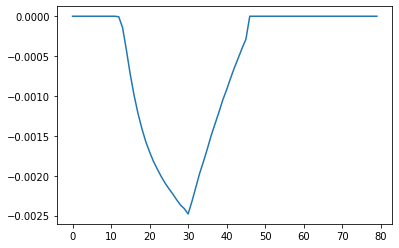

In [168]:
plt.plot(np.sum(map_estimate['all_lcs_0'][100:180,:],axis=1))

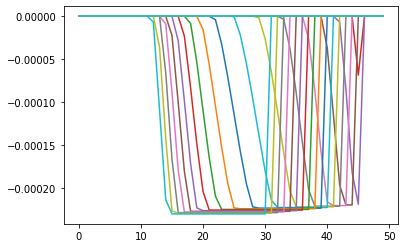

In [169]:
for n in range(n_steps):
    plt.plot(map_estimate['all_lcs_0'][100:150,n])
    

In [171]:
map_estimate

{'b_interval__': array(52.92713253),
 'log_depths_interval__': array([463.41370744, 463.41370744, 463.41370744, 463.41370744,
        463.41370744, 463.41370744, 463.41370744, 463.41370744,
        463.41370744, 463.41370744, 463.41370744]),
 'dust_vel_interval__': array(9.75948903),
 'log_rad_growth_interval__': array(-743.0438487),
 'log_dust_dispersion_interval__': array(463.41370744),
 'u_star_tess_quadlimbdark__': array([-672.4653046,    1.7406311]),
 'b': array(1.333),
 'log_depths': array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]),
 'dust_vel': array(1.24995669),
 'log_rad_growth': array(-6.),
 'log_dust_dispersion': array(10.),
 'u_star_tess': array([ 1.61010874e-146, -6.63840054e-147]),
 'all_lcs_0': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'disp_lc_0': array

In [170]:
for n in range(n_steps):
    plt.plot(map_estimate['all_lcs_0'][100:150,n]*map_estimate['dispersion'][n])
    

KeyError: 'dispersion'

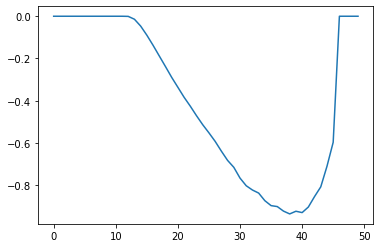

In [157]:
plt.plot(map_estimate['stacked_lc'][100:150])

In [46]:
phase

array([965.6697    , 965.67074232, 965.6717845 , ..., 975.71968305,
       975.72072522, 975.7217674 ])

In [48]:
t[rounded_phase==trns_numbers[0]]

array([1197.94110198, 1197.94178319, 1197.94246431, 1197.94314533,
       1197.94382644, 1197.94450766, 1197.94518878, 1197.94586999,
       1197.94655111, 1197.94723222, 1197.94791344, 1197.94859456,
       1197.94927557, 1197.94995679, 1197.9506379 , 1197.95131902,
       1197.95200014, 1197.95268135, 1197.95336247, 1197.95404359,
       1197.9547247 , 1197.95540582, 1197.95608693, 1197.95676815,
       1197.95744927, 1197.95813038, 1197.9588116 , 1197.95949271,
       1197.96017373, 1197.96085485, 1197.96153606, 1197.96221718,
       1197.9628983 , 1197.96357951, 1197.96426063, 1197.96494184,
       1197.96562286, 1197.96630398, 1197.96698509, 1197.96766631,
       1197.96834743, 1197.96902854, 1197.96970976, 1197.97039087,
       1197.97107209, 1197.97175311, 1197.97243422, 1197.97311534,
       1197.97379655, 1197.97447767, 1197.97515889, 1197.97584   ,
       1197.97652112, 1197.97720214, 1197.97788335, 1197.97856447,
       1197.97924558, 1197.9799268 , 1197.98060792, 1197.98128

In [33]:
xo.LimbDarkLightCurve?
#(u_star_tess).get_light_curve?

In [ ]:
xo.LimbDarkLightCurve().get_light_curve

In [ ]:
xo.LimbDarkLightCurve(u_star_tess).get_light_curve

In [25]:
ttx.Unique?

In [5]:
tt.lt?

In [148]:
tt.linspace?

Object `tt.linspace` not found.


149597870700.0

In [103]:
paramdic['Ms']=1.0*u.Msun
paramdic['Rs']=1.0*u.Rsun
paramdic['P']=1.0*u.day
paramdic['t_0']=0.25
paramdic['b']=0.2
paramdic['dust_dispersion']=1.04
paramdic['dust_vel']=1.01

EvapModel(t, paramdic)

0.0


TypeError: No model on context stack, which is needed to instantiate distributions. Add variable inside a 'with model:' block, or use the '.dist' syntax for a standalone distribution.

In [97]:
trns_numbers*paramdic['P'].value

array([0., 1., 2., 3., 4.])

In [75]:
xo.orbits.KeplerianOrbit?

In [ ]:
Ms=1.0*u.Msun
P=365.25*u.day
paramdic={'dust_vel':

In [ ]:
    sma_circ    = (c.G*Ms*P**2/(4*np.pi**2))**(1/3)
    if paramdic['dust_vel']>=0:
        ecc_phantom = 1-(sma_circ/(c.G*Ms))*(np.sqrt(c.G*Ms)/sma_circ+paramdic['dust_vel'])**2
    elif paramdic['dust_vel']<0:
        ecc_phantom = 1-(sma_circ/(c.G*Ms))*(np.sqrt(c.G*Ms)/sma_circ+paramdic['dust_vel'])**2
        #(np.sqrt((c.G*Ms)/sma_circ)+paramdic['dust_vel'])**2/(c.G*Ms)-1/sma_circ
    per_phantom = np.sqrt((4*np.pi**2*sma_circ/(1+ecc_phantom)**3)/(c.G*Ms))


In [18]:
1.41**2-1

0.9880999999999998

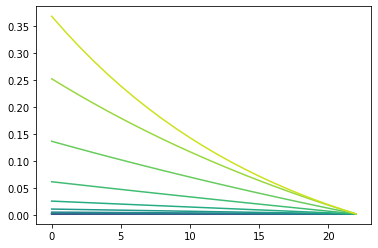

In [127]:
import seaborn as sns
sns.set_palette("viridis",12)
for log_rad_growth in np.linspace(-10,1.0,12):
    init_planet_ratio = 0.002
    planet_ratios_init= init_planet_ratio+(1+np.exp(log_rad_growth))**np.linspace(2,1,n_steps)
    planet_ratios     = (planet_ratios_init-planet_ratios_init[-1])/(2*planet_ratios_init[0])+init_planet_ratio
    plt.plot(planet_ratios)


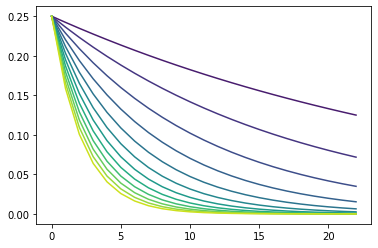

In [142]:
for log_dust_dispersion in np.linspace(0,10,12):
    dispersion  = 0.25/(1.0+np.exp(log_dust_dispersion))**(np.linspace(0,1,n_steps))
    plt.plot(dispersion)
